## 2) Trends and Correlation

In the time I have spent participating in the fantasy golf league, two metrics have sood out in my mind as important for gauging the potential success of a player at any given tournament:

<ol>
    <li>How have they been playing recently?  Has their driving and putting been good, or are they in a rut?</li>
    <li>Do they play well at the course hosting this week's tournament?  How have they finished in the last few years?</li>
</ol>

In the following section, I will evaluate these notions objectively and identify any trends and correlations I might be able to include in the model.  I'll break it up into the following sections:

<ol>
    <li>Normalization of the <em>place_adj</em> target variable</li>
    <li>One-way ANOVA analysis of select players' performance by course</li>
    <li>ACF and PACF analysis of each strokes-gained feature</li>
</ol>

I'll proceed by investigating the data associated with Patrick Reed and extend it to the full set of players once the ideas have been developed.  First, we'll load our cleaned PGA Finish Projections dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import pickle

df_clean = pd.read_excel('C:\\Users\\rbush\\Documents\\Projects\\PGA Finish Projections\\PGA Finish Projections_cleaned data.xlsx')

In [2]:
fields = ['player', 'player_id', 'tournament_name', 'tournament_id', 'course', 'course_id', 'region', 'region_id', 'season', 
          'days_from_today', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total', 'nan', 'mc', 'strokes', 'strokes_rel_par', 'place_adj']

In [3]:
features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

with open('sg_features.pkl', 'wb') as outfile:
    pickle.dump(features, outfile)

In [4]:
players = df_clean['player'].unique().tolist()

In [5]:
tournaments = df_clean['tournament_name'].unique().tolist()

In [6]:
courses = df_clean['course'].unique().tolist()

In [7]:
from scipy import stats

In [8]:
df_preed = df_clean.loc[df_clean['player']=='Patrick Reed']

In [9]:
target_dist = df_preed[['place_adj','mc']]

In [10]:
df_preed.columns

Index(['Unnamed: 0', 'player', 'player_id', 'tournament_name', 'tournament_id',
       'course', 'course_id', 'region', 'region_id', 'season',
       'days_from_today', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g',
       'sg_total', 'nan', 'mc', 'strokes', 'strokes_rel_par', 'place_adj',
       'nan_count', 'tourn_count'],
      dtype='object')

In [11]:
import warnings
warnings.filterwarnings("ignore")

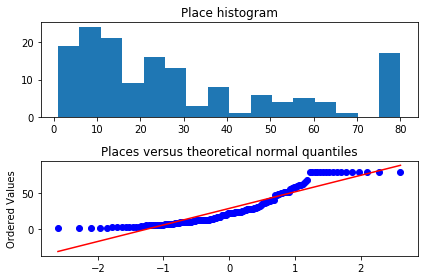

In [12]:
fig = pl.figure()

ax1 = fig.add_subplot(211)
pl.hist(x = target_dist['place_adj'], bins = 16)
ax1.set_title('Place histogram')

ax2 = fig.add_subplot(212)
prob = stats.probplot(x = target_dist['place_adj'], dist = 'norm', plot = ax2)
ax2.set_xlabel('')
ax2.set_title('Places versus theoretical normal quantiles')

fig.tight_layout()
fig.show()

In the plot above, two things stand out:

<ol>
    <li>While Patrick Reed has a substantial number of high-place finishes, he also has missed quite a few cuts which are likely to skew any modeling results if we leave them un-treated.</li>
    <li>The histogram is skewed left and is not normally distributed.  This suggests we will want to transform the place data for any simple statistical tests or regressive modeling.</li>
</ol>

In the following cells, we will omit the missed-cut results and use a [Box-Cox transformation](https://www.statisticshowto.com/box-cox-transformation/) to ensure our target variable normally distributed.

#### Normalization of <em>place_adj</em>

In [13]:
target_dist_adj = target_dist.loc[target_dist['mc']==0]

In [14]:
place_transform, lam = stats.boxcox(target_dist_adj['place_adj'])

In [15]:
target_dist_adj['place_transform'] = place_transform

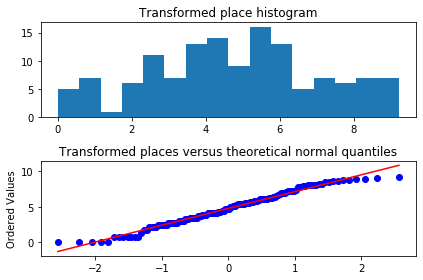

In [16]:
fig = pl.figure()

ax1 = fig.add_subplot(211)
pl.hist(x = target_dist_adj['place_transform'], bins = 16)
ax1.set_title('Transformed place histogram')

ax2 = fig.add_subplot(212)
prob = stats.probplot(x = target_dist_adj['place_transform'], dist = 'norm', plot = ax2)
ax2.set_xlabel('')
ax2.set_title('Transformed places versus theoretical normal quantiles')

fig.tight_layout()
fig.show()

Now that we have defined an appropriate normal transformation for our target variable, we can begin conducting statistical analyses which rely on assumptions of normality.  First and foremost, we will test whether the certain courses influence the place Patrick Reeds ends a given tournament.  Said more simply, we will see if he plays better on some courses than others.

To do so, we will make use of a [one-way ANOVA test](https://www.pythonfordatascience.org/anova-python/).  The ANOVA allows us to investigate whether a categorical feature variable has a significant impact on our target variable.  For our purposes, we will see whether the finishes on particular courses drive statistically significant place differences.  The ANOVA test relies on the following assumptions:

<ol>
    <li>The population distribution is normal</li>
    <li>Sample means have equal variance</li>
    <li>Sample occurrences are independent</li>
</ol>

With our use of the [Box-Cox transformation](https://www.statisticshowto.com/box-cox-transformation/), we have assured that the population distribution is normal.  Additionally, we will make the assumption that each tournament finish is an independent from all others (i.e. preparation is assumed to be constant for a full season, and the finish at one tournament does not interfere with another later on in the season).  Thus, the only assumption we have left to cvalidate is the variance associated with our samples.

In the following cells, we will continue to evaluate data associated with Patrick Reed.  First we will aggregate the tournament records by golf course.  Then, we will examine the variance by sampling several times and calculating sample variance for a number of courses.  Then, we will finish by calculating an [F score](https://www.pythonfordatascience.org/anova-python/) for the ANOVA on each golf course to assess whether he experiences disproportionately good performance at some golf courses.

In [17]:
df_preed = df_preed.loc[df_preed['mc'] == 0]

In [18]:
df_preed['place_adj'] = place_transform

##### One-way ANOVA test on golf courses

In [19]:
course_season = df_preed.loc[df_preed['mc'] == 0][['course', 'season', 'place_adj']]
course_mean = df_preed.loc[df_preed['mc'] == 0][['course', 'place_adj']]

In [20]:
course_mean = course_mean.groupby(['course']).agg(['mean', 'count'])

In [21]:
course_mean['obs_thresh'] = 0
for row in range(len(course_mean.index)):
    if course_mean.iloc[row,1] >= 4:
        course_mean.iloc[row,2] = 1
    else:
        pass

In [22]:
course_mean.groupby('obs_thresh').count().iloc[:,1]

obs_thresh
0    51
1    14
Name: (place_adj, count), dtype: int64

Above, we can see that there are 14 golf courses at which Patrick has played at least 4 tournaments.  Because we want to evaluate our assumption that there is similar variance between each of our sample groups, we'll choose these courses as they'll have at least a few records from which to reasonably calculate variance.

In [23]:
course_anova = course_mean.loc[course_mean['obs_thresh'] == 1]

In [24]:
course_season = course_season.set_index('course')

In [25]:
course_anova = course_anova.join(course_season)
course_anova = course_anova.loc[:,'place_adj']
courses = course_anova.index.unique()

In [26]:
def place_variance(df, levels):
    variances = {}
    for level in levels:
        dfi = df[level]
        mean = dfi.mean()
        num = dfi.count()
        diff_vec = dfi-mean
        diff_vec_sq = diff_vec**2
        
        var = diff_vec_sq.sum()/(num-1)
        variances[level] = var
        
    return(variances)

In [27]:
course_variance = place_variance(course_anova, courses)

In [28]:
sorted(course_variance.values())

[1.3488854715969796,
 1.6243510949594397,
 1.993048390923174,
 2.508356132859395,
 3.465127020521295,
 3.6273092882706734,
 4.543669493019291,
 5.58628390030023,
 8.430147860225356,
 8.547105634452231,
 8.799207126905694,
 9.32789074301707,
 9.881710763103522,
 14.623290006201742]

As we can see in the list of course variances above, there are groups of 5 courses with similar <em>place_adj</em> variances between ~1 and ~3 and ~9 and ~10.  I will run a one-way ANOVA tests on the first group to determine whether any of the courses demonstrates significantly better performance relative to its peers. If not, I will move on to the second.

In [29]:
course_list = [course for course, variance in course_variance.items() if variance > 1 and variance < 4]
print(course_list)

['Albany', 'East Lake', 'Firestone', 'Pebble Beach', 'TPC River Highlands', 'TPC Sawgrass']


In [30]:
anova_courses = len(course_list)

print('For the following analysis, there are %s courses associated with the group' % (anova_courses))

For the following analysis, there are 6 courses associated with the group


In [31]:
course_anova = pd.DataFrame(course_list)
course_anova = course_anova.set_index(course_anova.iloc[:,0])
course_anova = course_anova.join(course_season)
course_anova.drop([0, 'season'], axis = 1, inplace = True)
course_anova.reset_index(inplace = True)

For our ANOVA test, we'll import the researchpy and scipy.stats packages:  

<ol>
    <li>researchpy has the function <em>summary_cont()</em> which displays all of the useful evaluation metrics involved in the F-test which ANOVA tests use to assess categorical variable influences.  We will use those tables to understand which categorical variables are significant.</li>
    <li>scipy.stats has the function <em>f_oneway</em> which takes each categorical variables' values as lists, and generates a single F-score and p-value which determines whether the categorical variables significantly influence the target.</li>
</ol>

Together, we will use the packages to decide whether Patrick Reed plays significantly better at any of the selected course, or if his performance is not correlated with any particular tournament-site.

In [32]:
import researchpy as rp
import scipy.stats as stats

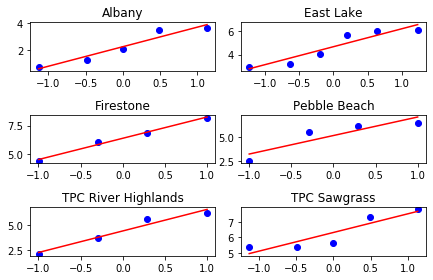

In [33]:
fig = pl.figure()

ax = ['ax'+str(num) for num in range(len(course_list))]
subplot = 321
for course_index in range(len(course_list)):
    ax[course_index] = fig.add_subplot(subplot)
    prob = stats.probplot(x = course_anova.loc[course_anova['index']==course_list[course_index]].iloc[:,1], 
                          dist = 'norm', 
                          plot = ax[course_index])
    ax[course_index].set_xlabel('')
    ax[course_index].set_ylabel('')
    ax[course_index].set_title(course_list[course_index])
    
    subplot = subplot+1

fig.tight_layout()
fig.show()

In the plots above, we can see that his finishes are normally distributed for the group of courses being considered.  This satisfies our final assumption required for a one-way ANOVA, and we can feel confident in applying the test to his finishes at these courses.

In [34]:
rp.summary_cont(course_anova['place_adj'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,place_adj,28.0,4.8189,1.9754,0.3733,4.0529,5.5849


In [35]:
rp.summary_cont(course_anova['place_adj'].groupby(course_anova['index']))

,N,Mean,SD,SE,95% Conf.,Interval
index,,,,,,
Albany,5,2.2718,1.2745,0.5700,0.6893,3.8543
East Lake,6,4.6682,1.4118,0.5763,3.1867,6.1497
Firestone,4,6.3894,1.5838,0.7919,3.8693,8.9096
Pebble Beach,4,5.1713,1.8615,0.9307,2.2093,8.1334
TPC River Highlands,4,4.4366,1.9045,0.9523,1.4061,7.4672
TPC Sawgrass,5,6.3143,1.1614,0.5194,4.8722,7.7563


The average normalized finish for the first group of courses was 4.846 with a 95% confidence interval from 0.6884 to 3.8827.  Within that group, we can see three courses which deviate substantially from that group mean: Albany, Firestone, and TPC Sawgrass.

In [36]:
course_place_adj = []
for course in course_list:
    place_adj = [value for value in course_anova.loc[course_anova['index']==course].iloc[:,1]]
    course_place_adj.append(place_adj)

In [37]:
stats.f_oneway(course_place_adj[0],
               course_place_adj[1],
               course_place_adj[2],
               course_place_adj[3],
               course_place_adj[4],
               course_place_adj[5])

F_onewayResult(statistic=4.751037432883345, pvalue=0.0042879596190475424)

With our scipy.stats one-way ANOVA test, we have an F-statistic of 4.687 and a p-value of 0.005.  When evaluating the ANOVA output, it is conventional to compare the p-value to 0.05.  In the event that the p-value is less than 0.05, one can conclude that there is a 95% level of confidence that the categorical variables in the group significantly impact the target variable.

Because the p-value is less than 0.05, we can conclude that Patrick Reed plays significantly better on at least one course.  Given those findings, we can confidently conclude <em>course</em> will be a meaningful variable in our model.

#### ACF and PACF on strokes-gained features

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import seaborn as sn

In [39]:
df_preed.head()

,Unnamed: 0,player,player_id,tournament_name,tournament_id,course,course_id,region,region_id,season,...,sg_ott,sg_t2g,sg_total,nan,mc,strokes,strokes_rel_par,place_adj,nan_count,tourn_count
18947,21519,Patrick Reed,295,Wells Fargo Championship,137,Quail Hollow,39,"Charlotte, NC",36,2021,...,0.38,0.75,2.44,0,0,279,-5,2.448913,45,156
18949,21523,Patrick Reed,295,The Players Championship,141,TPC Sawgrass,27,"Ponte Vedra Beach, FL",26,2021,...,0.23,0.45,1.38,0,0,283,-5,5.396214,45,156
18951,21525,Patrick Reed,295,WGC-Workday Championship,180,The Concession Golf Club,67,"Bradenton, FL",61,2021,...,0.04,1.41,2.37,0,0,277,-11,3.236203,45,156
18952,21526,Patrick Reed,295,Farmers Insurance Open,6,Torrey Pines,6,"La Jolla, CA",6,2021,...,0.38,1.93,3.41,0,0,274,-14,0.000000,45,156
18954,21528,Patrick Reed,295,Sentry Tournament of Champions,182,Kapalua Resort,43,"Kapalua, Maui, HI",38,2021,...,0.31,-0.86,0.07,0,0,277,-15,5.267271,45,156


In [40]:
df_preed.groupby('season')['tournament_id'].count()

season
2015    20
2016    24
2017    23
2018    19
2019    22
2020    18
2021     8
Name: tournament_id, dtype: int64

In [41]:
tournament_count_min = 15
tournament_count_max = 25

In [42]:
sg_total_series = [value for value in df_preed['sg_total']]

In [43]:
residual_sq_sums = []
for period in range(tournament_count_min, tournament_count_max+1):
    sg_decomposed = seasonal_decompose(sg_total_series, model = 'additive', period = period)
    residuals = np.array(sg_decomposed.resid)
    residuals = residuals[np.logical_not(np.isnan(residuals))]
    residual_sq_sum = np.sum(residuals)**2
    residual_plot_tuple = (period, residual_sq_sum)
    residual_sq_sums.append(residual_plot_tuple)
    
residual_sq_sums = pd.DataFrame(residual_sq_sums)

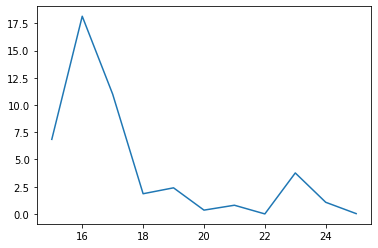

In [44]:
pl.plot(residual_sq_sums.iloc[:,0], residual_sq_sums.iloc[:,1])

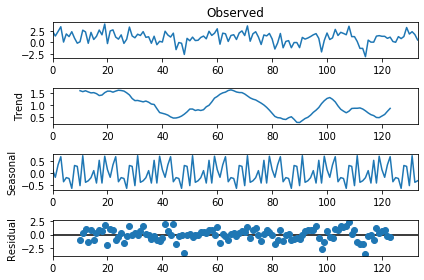

In [45]:
sg_decomposed = seasonal_decompose(sg_total_series, model = 'additive', period = 20)
sg_decomposed.plot()
pl.show()

In [46]:
def difference(series):
    
    diff = []
    
    for i in range(1, len(series)):
        value = series[i]-series[i-1]
        diff.append(value)
    
    return pd.DataFrame(diff)

In [47]:
sg_total_series_diff = pd.DataFrame(difference(sg_total_series))

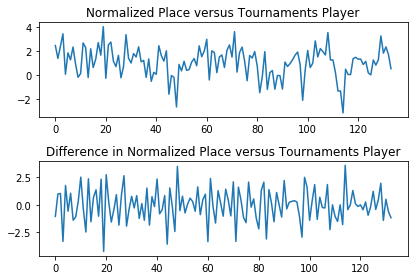

In [48]:
fig = pl.figure()

ax0 = fig.add_subplot(211)
pl.plot(sg_total_series)
ax0.set_title('Normalized Place versus Tournaments Player')

ax1 = fig.add_subplot(212)
pl.plot(sg_total_series_diff)
ax1.set_title('Difference in Normalized Place versus Tournaments Player')

pl.tight_layout()

In [49]:
result = adfuller(sg_total_series)

print(result, '\n')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

(-4.802854107393415, 5.370632275007748e-05, 3, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 377.091160698336) 

ADF Statistic: -4.802854
p-value: 0.000054
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


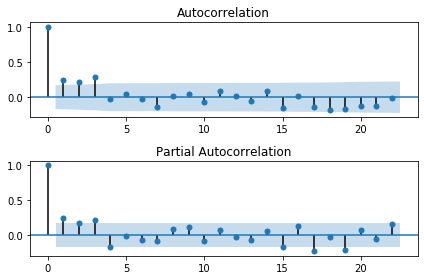

In [50]:
sg_total_df = pd.DataFrame(sg_total_series)
fig = pl.figure()

fig.add_subplot(211)
plot_acf(sg_total_df, ax=pl.gca())

fig.add_subplot(212)
plot_pacf(sg_total_df, ax=pl.gca())

pl.tight_layout()
pl.show()

From the auto-correlation plots on <em>sg_total</em>, it is clear that strokes-gained performnce for the 3 prior tournaments has some impact on strokes-gained for the week in question.  Additionally, we can see below that <em>sg_total</em> for a given week correlates strongly with the place for that week:

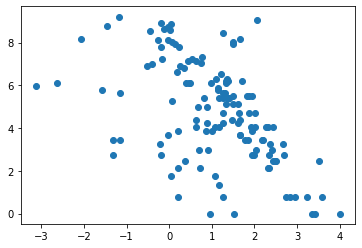

In [51]:
pl.scatter(df_preed['sg_total'], df_preed['place_adj'])

Because we know that <em>sg_total</em> has a significant impact on how a player finishes for a week, and that strokes-gained features from 3 weeks prior have a weak influence on performance for the week, we will add a new feature for each strokes-gained field which represent the statistic in question lagged 1, 2, and 3 weeks as new columns.

In [52]:
df_list = []

for player in players:
    dfi = df_clean.loc[df_clean['player']==player]
    df_list.append(dfi)

In [53]:
df_list[0].head()

,Unnamed: 0,player,player_id,tournament_name,tournament_id,course,course_id,region,region_id,season,...,sg_ott,sg_t2g,sg_total,nan,mc,strokes,strokes_rel_par,place_adj,nan_count,tourn_count
0,0,Aaron Baddeley,1,AT&T Byron Nelson,1,NaN,0,NaN,0,2021,...,-1.75,0.94,-0.44,0,1,140,-4,80,17,126
1,1,Aaron Baddeley,1,AT&T Byron Nelson,1,TPC Craig Ranch,1,"McKinney, TX",1,2021,...,-1.75,0.94,-0.44,0,1,140,-4,80,17,126
2,2,Aaron Baddeley,1,Valspar Championship,2,Innisbrook,2,"Palm Harbor, FL",2,2021,...,-1.21,-2.33,-0.49,0,1,143,1,80,17,126
3,5,Aaron Baddeley,1,AT&T Pebble Beach Pro-Am,5,Pebble Beach,5,"Pebble Beach, CA",5,2021,...,0.60,-2.47,-1.74,0,1,144,0,80,17,126
4,6,Aaron Baddeley,1,Farmers Insurance Open,6,Torrey Pines,6,"La Jolla, CA",6,2021,...,-2.04,-1.25,-1.83,0,1,148,4,80,17,126


In [54]:
lag_features = set()

In [55]:
for feature in features:
    for df in df_list:
        for week_itrvl in range(1,4):
            df[feature+str(week_itrvl)] = df[feature].shift(-1*week_itrvl)
            lag_features.add(feature+str(week_itrvl))

In [56]:
lag_features = list(lag_features)
add_features = features+lag_features

In [57]:
df_lag = df_list[0]

In [58]:
for df in df_list[1:]:
    df_lag = df_lag.append(df)

In [59]:
df_lag = df_lag.dropna()
df_clean = df_lag

In [60]:
df_clean.drop(columns = ['Unnamed: 0', 'player_id', 'tournament_id', 'course_id', 'region_id', 'days_from_today', 'region', 'season', 'nan', 'mc', 'strokes']).head()

,player,tournament_name,course,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,strokes_rel_par,...,sg_app3,sg_ott1,sg_ott2,sg_ott3,sg_t2g1,sg_t2g2,sg_t2g3,sg_total1,sg_total2,sg_total3
1,Aaron Baddeley,AT&T Byron Nelson,TPC Craig Ranch,-1.38,0.45,2.25,-1.75,0.94,-0.44,-4,...,0.42,-1.21,0.60,-2.04,-2.33,-2.47,-1.25,-0.49,-1.74,-1.83
2,Aaron Baddeley,Valspar Championship,Innisbrook,1.84,-0.73,-0.39,-1.21,-2.33,-0.49,1,...,0.07,0.60,-2.04,-0.22,-2.47,-1.25,-0.86,-1.74,-1.83,-4.00
3,Aaron Baddeley,AT&T Pebble Beach Pro-Am,Pebble Beach,0.73,-0.41,-2.67,0.60,-2.47,-1.74,0,...,0.19,-2.04,-0.22,-0.35,-1.25,-0.86,-1.09,-1.83,-4.00,0.50
4,Aaron Baddeley,Farmers Insurance Open,Torrey Pines,-0.59,0.38,0.42,-2.04,-1.25,-1.83,4,...,-1.81,-0.22,-0.35,-0.84,-0.86,-1.09,-1.58,-4.00,0.50,-1.78
5,Aaron Baddeley,The American Express,La Quinta CC,-3.14,-0.72,0.07,-0.22,-0.86,-4.00,-1,...,0.04,-0.35,-0.84,0.08,-1.09,-1.58,0.38,0.50,-1.78,0.27


In [61]:
df_clean.head()

,Unnamed: 0,player,player_id,tournament_name,tournament_id,course,course_id,region,region_id,season,...,sg_app3,sg_ott1,sg_ott2,sg_ott3,sg_t2g1,sg_t2g2,sg_t2g3,sg_total1,sg_total2,sg_total3
1,1,Aaron Baddeley,1,AT&T Byron Nelson,1,TPC Craig Ranch,1,"McKinney, TX",1,2021,...,0.42,-1.21,0.60,-2.04,-2.33,-2.47,-1.25,-0.49,-1.74,-1.83
2,2,Aaron Baddeley,1,Valspar Championship,2,Innisbrook,2,"Palm Harbor, FL",2,2021,...,0.07,0.60,-2.04,-0.22,-2.47,-1.25,-0.86,-1.74,-1.83,-4.00
3,5,Aaron Baddeley,1,AT&T Pebble Beach Pro-Am,5,Pebble Beach,5,"Pebble Beach, CA",5,2021,...,0.19,-2.04,-0.22,-0.35,-1.25,-0.86,-1.09,-1.83,-4.00,0.50
4,6,Aaron Baddeley,1,Farmers Insurance Open,6,Torrey Pines,6,"La Jolla, CA",6,2021,...,-1.81,-0.22,-0.35,-0.84,-0.86,-1.09,-1.58,-4.00,0.50,-1.78
5,7,Aaron Baddeley,1,The American Express,7,La Quinta CC,7,"La Quinta, CA",7,2021,...,0.04,-0.35,-0.84,0.08,-1.09,-1.58,0.38,0.50,-1.78,0.27


In [62]:
df_clean.to_excel('C:\\Users\\rbush\\Documents\\Projects\\PGA Finish Projections\\PGA Finish Projections_modeling data.xlsx')

In [63]:
df_clean.shape

(26228, 42)